In [54]:
# (inscrutable setup mumbo-jumbo)

%matplotlib inline

import numpy as np
import requests
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from os.path import exists
from matplotlib import animation
from numba import jit as execute_quickly

def show_with_extent(f, **kwargs):
    return plt.imshow(f, extent=(x[0,0], x[-1, 0], y[0, 0], y[0, -1]), **kwargs)
def show_field(f, **kwargs):
    return show_with_extent(f[:, ::-1].T, **kwargs)

In [55]:
if 1:
    # doubleSlit_WaterWaves.mp4, of Jun 12, 2018
    video_url = "https://uc6db32a6352cfd9b2e19d5de435.dl.dropboxusercontent.com/cd/0/get/AI-wO2o0jxY8tUa5SuDW9CgP3TNh10oNa-jk52ulDVZ_uowRCv2seh0Vps-pefyXNPo8XzlXbygvQ-TMtRJA0aDjLqLWLz9p6YGEDkHJfgb23xnvUcyLOOZ_XDSzyC2WfaUR9i9Q5_7KCl7fgUSVfYLnvjkhDHTY_om8GKt1mmw9Y_S92TCG62zTr-2EHWTAdKg/file?_download_id=5917241966891996173334094459728920198810283281548612923287063415612&_notify_domain=www.dropbox.com&dl=1"
    
    video_filename = "double-slit.mp4"

    # pixel coordinates of grid in source video
    top_left = (222, 79)
    bottom_left = (270, 914)
    bottom_right = (1027, 826)
    top_right = (977, 52)
    
    unit_grid_x, unit_grid_y = (19, 15)
    
    video_start_time = 3.7
    frames_per_sec = 30
    
    wave_speed = 25
    
comp_grid_x, comp_grid_y = (640, 480)

In [56]:
if not exists(video_filename):
    r = requests.get(video_url, stream=True)

    size = 0
    with open(video_filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=1024*1024):
            print(".", end="", flush=True)
            size += len(chunk)
            fd.write(chunk)
    print()
    print(f"received {size/1024/1024:.1f} MB...")

    print("done")

In [57]:
vid_reader = imageio.get_reader(video_filename,  'ffmpeg')

def get_frame(frame_nr):
    img = Image.fromarray(vid_reader.get_data(frame_nr)).convert("L")

    img = img.transform(
        (comp_grid_x, comp_grid_y), Image.QUAD,
        top_left + bottom_left + bottom_right + top_right,
        Image.BILINEAR)
    
    img = ImageEnhance.Contrast(img).enhance(2)
    
    return img

def get_frame_at_time(t):
    return get_frame(int(frames_per_sec*(t + video_start_time)))

In [58]:
x, y = np.mgrid[0:unit_grid_x:comp_grid_x*1j, 0:unit_grid_y:comp_grid_y*1j]

dx = x[1,0] - x[0,0]
dy = y[0,1] - y[0,0]

dt = 0.5 * min(dx, dy) / wave_speed

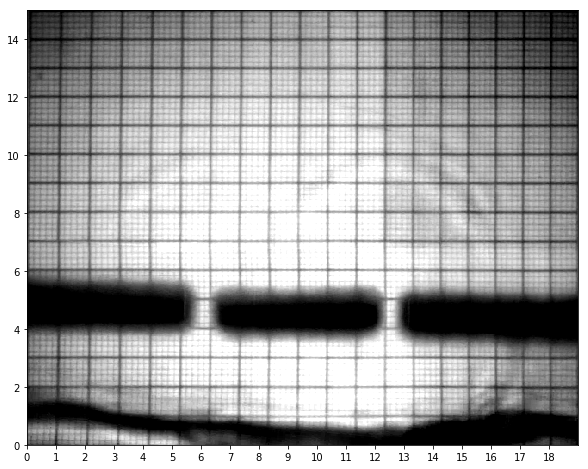

In [59]:
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, unit_grid_x))
show_with_extent(get_frame_at_time(0.1))

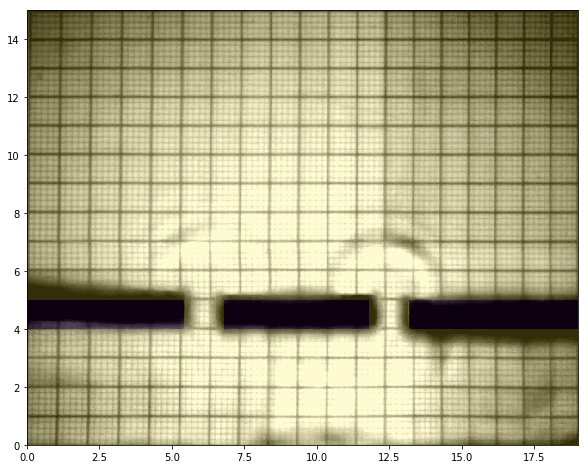

In [60]:
is_free_space = (np.abs(y-4.5) > 0.5) | (np.abs(x - 6.1) < 0.7) | (np.abs(x - 12.5) < 0.7)

plt.figure(figsize=(20, 8))
show_field(is_free_space)
show_with_extent(get_frame_at_time(0), alpha=0.8)

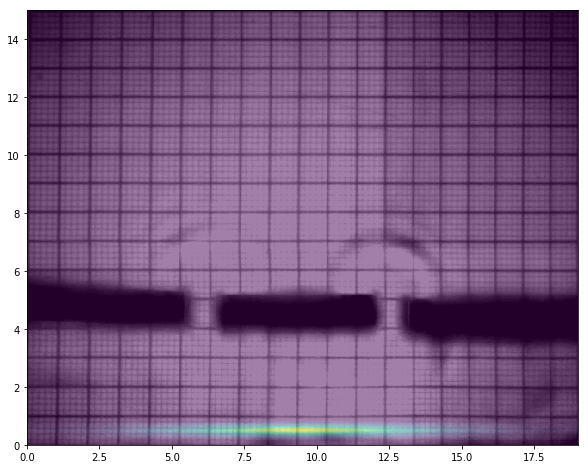

In [61]:
source_shape = np.exp(-30*((y-0.5)**2)) * (1-np.tanh(np.abs(0.3*(x-0.5*unit_grid_x)) - 0.95))

plt.figure(figsize=(20, 8))
show_field(source_shape)
show_with_extent(get_frame_at_time(0), alpha=0.5)

In [62]:
@execute_quickly
def bendiness(f, dx, dy):
    result = np.zeros_like(f)
    
    m, n = f.shape
    for i in range(1, m-1):
        for j in range(1, n-1):
            result[i, j] = (
                # 
                  1/dx**2 * (f[i-1,j] - 2*f[i,j] + f[i+1,j])
                + 1/dy**2 * (f[i,j-1] - 2*f[i,j] + f[i,j+1])
                )
            
    return result * is_free_space

In [65]:
ntimes = 1000
nvideo_frames = 100

fields_for_video = np.empty((nvideo_frames,) + x.shape)
frame_times = np.empty(nvideo_frames)

field = np.zeros_like(source_shape)
velocity = np.zeros_like(source_shape)

for i in range(ntimes):
    t = i * dt
    
    iframe = i//(ntimes//nvideo_frames)
    frame_times[iframe] = t
    fields_for_video[iframe] = field
    
    field = field + dt * wave_speed * velocity + dt * np.exp(-10*(t/wave_speed-1)**2) * source_shape
    velocity += dt * wave_speed * bendiness(field, dx, dy)

In [66]:
# inscrutable video rendering mumbo-jumbo - execute to see video
# This is yucky and not intended for the students to mess with/understand.

fig = plt.figure(figsize=(10, 7))

vmax = np.max(np.abs(fields_for_video)) * 0.05
sim_img = show_field(source_shape, vmax=vmax, vmin=-vmax)
real_img = show_with_extent(get_frame_at_time(0), alpha=0.5)
    
boundary = (1-is_free_space) * 200

def animate(i):
    sim_img.set_data((fields_for_video[i] - boundary)[:, ::-1].T)
    real_img.set_data(get_frame_at_time(frame_times[i]))
    return (sim_img, real_img)

anim = animation.FuncAnimation(
    fig, animate, frames=nvideo_frames, interval=50, blit=True)

from IPython.display import HTML
html = HTML(anim.to_html5_video())
plt.clf()

html

<Figure size 720x504 with 0 Axes>